# SITCOM-989 - M1M3 Inertia Compensation Performance

We need plots and metrics to evaluate the performance of the M1M3 Inertia Compensation System as described in [SITCOM-989].    
Examples of plots are:

* Hardpoint Load Cell Forces Minima and Maxima during slews as a function of time.
* Correlate the plots above with accelerations, velocities, and positions.
* (any other ideas?)

Petr asked to analyse the data obtained when slewing the telescope around 80 deg in elevation with and without inertia forces. 
The two datasets below that he used as an example contain movement from -100 deg in azimuth to 100 deg in a single slew. 
On both cases, we are using 30% motion settings in azimuth. 

* [M1M3 TMA Inertial forces Chronograph Dashboard on 2023-08-02 22:02 - 2023-08-02 22:04 UTC]
* [M1M3 TMA Inertial forces Chronograph Dashboard on 2023-07-28 02:15 - 2023-07-28 02:17 UTC]

Added a new dataset containing similar data but with 50% azimuth motion settinds. 

* [M1M3 TMA Inertial forces Chronograph Dashboard on 2023-08-03 03:20 - 2023-08-03 03:22 UTC]

[SITCOM-989]: https://jira.lsstcorp.org/browse/SITCOM-989


[M1M3 TMA Inertial forces Chronograph Dashboard on 2023-08-02 22:02 - 2023-08-02 22:04 UTC]: https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/252?redirect=%2Flogin%3Fredirect%3D%252Fsources%252F1%252Fdashboards%252F252%253Frefresh%253D30s%2526tempVars%255BDownsample%255D%253DDefault%2526tempVars%255BFunction%255D%253Draw%2526lower%253Dnow%2528%2529%252520-%25252015m%2526zoomedLower%253D2023-08-02T21%25253A23%25253A19.366Z%2526zoomedUpper%253D2023-08-02T21%25253A23%25253A23.843Z&refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=mean%28%29&lower=2023-08-02T20%3A00%3A00.000Z&upper=2023-08-03T02%3A00%3A00.000Z&zoomedLower=2023-08-02T22%3A02%3A24.799Z&zoomedUpper=2023-08-02T22%3A04%3A02.450Zhttps://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/252?redirect=%2Flogin%3Fredirect%3D%252Fsources%252F1%252Fdashboards%252F252%253Frefresh%253D30s%2526tempVars%255BDownsample%255D%253DDefault%2526tempVars%255BFunction%255D%253Draw%2526lower%253Dnow%2528%2529%252520-%25252015m%2526zoomedLower%253D2023-08-02T21%25253A23%25253A19.366Z%2526zoomedUpper%253D2023-08-02T21%25253A23%25253A23.843Z&refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=mean%28%29&lower=2023-08-02T20%3A00%3A00.000Z&upper=2023-08-03T02%3A00%3A00.000Z&zoomedLower=2023-08-02T22%3A02%3A24.799Z&zoomedUpper=2023-08-02T22%3A04%3A02.450Z


[M1M3 TMA Inertial forces Chronograph Dashboard on 2023-07-28 02:15 - 2023-07-28 02:17 UTC]:https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/252?redirect=%2Flogin%3Fredirect%3D%252Fsources%252F1%252Fdashboards%252F252%253Frefresh%253D30s%2526tempVars%255BDownsample%255D%253DDefault%2526tempVars%255BFunction%255D%253Draw%2526lower%253Dnow%2528%2529%252520-%25252015m%2526zoomedLower%253D2023-08-02T21%25253A23%25253A19.366Z%2526zoomedUpper%253D2023-08-02T21%25253A23%25253A23.843Z&refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=mean%28%29&lower=2023-07-28T02%3A00%3A00.000Z&upper=2023-07-28T03%3A30%3A00.000Z&zoomedLower=2023-07-28T02%3A15%3A45.730Z&zoomedUpper=2023-07-28T02%3A17%3A11.966Z

[M1M3 TMA Inertial forces Chronograph Dashboard on 2023-08-03 03:20 - 2023-08-03 03:22 UTC]:https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/252?redirect=%2Flogin%3Fredirect%3D%252Fsources%252F1%252Fdashboards%252F252%253Frefresh%253D30s%2526tempVars%255BDownsample%255D%253DDefault%2526tempVars%255BFunction%255D%253Draw%2526lower%253Dnow%2528%2529%252520-%25252015m%2526zoomedLower%253D2023-08-02T21%25253A23%25253A19.366Z%2526zoomedUpper%253D2023-08-02T21%25253A23%25253A23.843Z&refresh=Paused&tempVars%5BDownsample%5D=5Hz&tempVars%5BFunction%5D=mean%28%29&lower=2023-08-03T03%3A20%3A00.000Z&upper=2023-08-03T03%3A22%3A00.000Z

## Notebook Preparation

In [1]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.time import Time, TimeDelta
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from scipy import integrate

from lsst.sitcom import vandv
from lsst.summit.utils.efdUtils import EfdClient, getDayObsForTime, getEfdData, makeEfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAEvent

In [2]:
efd_client = makeEfdClient()
event_maker = TMAEventMaker()

In [3]:
number_of_hardpoints = 6
measured_forces_topics = [f"measuredForce{i}" for i in range(number_of_hardpoints)]
tai_utc_offset = timedelta(seconds=37)

### Helper Functions and Classes

#### SlewDataSet

In [18]:
class SlewDataSet:
    """
    Hold all the data associated with a slew.
    
    Parameters
    ----------
    name : str
        Human readable name
    begin : str or `astropy.time.Time`
        Start date and time in ISO format and in UTC.
    end : str or `astropy.time.Time`
        End date and time in ISO format and in UTC.
        
    Attributes
    ----------
    df : pd.DataFrame | None = None
        Table containing the HP measured forces (the columns should be 
        `measuredForces0`, `measuredForces1`, etc.). The index should be 
        a timestamp. 
    stats : pd.DataFrame | None = None
        Table containing the min/max/ptp values for each HP measured forces 
        in the beginning of a slew and at the end of a slew. 
    events : list[TMAEvent] | None = None
        TMA slew events obtained via TMAEventMaker to have a more exact 
        timestamp from MTMount.
    inner_pad : int
        Inner time pad in seconds added to the timestamps the represent the 
        beginning and the end of the interval where the acceleration is (almost) 
        zero. 
    outer_pad : int
        Outer time pad in seconds added to the `begin` and `end` timestamps 
        to allow considering data outside the event range. 
    """
    def __init__(self, name : str, begin : str | Time, end : str | Time, inner_pad : int = 0, outer_pad : int = 0):
        self.name = name
        self.begin = begin if isinstance(begin, Time) else Time(begin, scale="utc", format="isot")
        self.end = end if isinstance(end, Time) else Time(end, scale="utc", format="isot")
        self.inner_pad = inner_pad
        self.outer_pad = outer_pad
        
    async def start(self):
        """Performs all the measurements"""
        self.df = await self.query_dataset()
        self.stats = self.get_stats()
        self.event = self.get_tma_slew_event()
        self.integrals = self.get_integral()
        
    async def query_dataset(self):
        """
        Queries all the relevant data, resample them to have the same requency and merge them in a single dataframe.
            
        Returns
        -------
        pd.DataFrame
        """    
        hp_measured_forces = await efd_client.select_time_series(
            "lsst.sal.MTM1M3.hardpointActuatorData", 
            measured_forces_topics, 
            self.begin,  
            self.end, 
        )
        
        tma_az = await efd_client.select_time_series(
            "lsst.sal.MTMount.azimuth", 
            ["timestamp", "actualTorque", "actualVelocity"], 
            self.begin, 
            self.end
        )

        tma_az = tma_az.rename(
            columns={
                "actualTorque": "az_actual_torque", 
                "actualVelocity": "az_actual_velocity"
            }
        )
        tma_az["timestamp"] = pd.to_datetime(tma_az["timestamp"], unit="s") - tai_utc_offset
        tma_az.set_index("timestamp", inplace=True)
        tma_az.index = tma_az.index.tz_localize('UTC')
        
        tma_el = await efd_client.select_time_series(
            "lsst.sal.MTMount.elevation", 
            ["timestamp", "actualTorque", "actualVelocity"], 
            self.begin,
            self.end,
        )
        
        tma_el = tma_el.rename(
            columns={
                "actualTorque": "el_actual_torque", 
                "actualVelocity": "el_actual_velocity"
            }
        )
        tma_el["timestamp"] = pd.to_datetime(tma_el["timestamp"], unit="s") - tai_utc_offset 
        tma_el.set_index("timestamp", inplace=True)
        tma_el.index = tma_el.index.tz_localize('UTC')
        
        merge_cfg = {
            "left_index": True, 
            "right_index": True, 
            "tolerance": timedelta(seconds=1), 
            "direction": "nearest"
        }
        
        merged_df = pd.merge_asof(hp_measured_forces, tma_az, **merge_cfg)
        merged_df = pd.merge_asof(merged_df, tma_el, **merge_cfg)
        merged_df[["az_actual_torque", "el_actual_torque"]] = \
            1e-3 * merged_df[["az_actual_torque", "el_actual_torque"]]
        
        return merged_df
    
    def get_stats(self):
        """
        Calculate statistics for each column in a given dataset.

        Returns
        -------
        pandas.DataFrame
            A DataFrame containing calculated statistics for each column in the dataset.
            For each column, the statistics include minimum, maximum, and peak-to-peak values.

        Notes
        -----
        This function computes statistics for each column in the provided dataset. It utilizes the `get_minmax` function
        to calculate minimum, maximum, and peak-to-peak values for each column's data.
        """
        stats = pd.DataFrame(
            data=[self.get_minmax(self.df[col]) for col in self.df.columns],
            index=self.df.columns
        )
        return stats
    
    def get_midppoint(self):
        """Returns the halfway point between begin and end"""        
        return self.df.index[len(self.df.index) // 2]
    
    @staticmethod
    def get_minmax(s):
        """
        Calculate minimum, maximum, and peak-to-peak values for a data-series.

        Parameters
        ----------
        s : pandas.Series
            The input pandas Series containing data.

        Returns
        -------
        pandas.Series
            A Series containing the following calculated values for the two halves of the input Series:
            - min: Minimum value of the Series.
            - max: Maximum value of the Series.
            - ptp: Peak-to-peak (ptp) value of the Series (abs(max - min)).
            
        Example
        -------
        >>> import pandas as pd
        >>> data = [1, 2, 3, 4, 5, 6, 7, 8]
        >>> series = pd.Series(data, name='example')
        >>> minmax_values = get_minmax(series)
        """
        result = pd.Series(
            data=[
                s.min(),
                s.max(),
                np.ptp(s),
            ],
            index=[
                "min",
                "max",
                "ptp",
            ],
            name=s.name,
        )

        return result
    
    def get_tma_slew_event(self, t_pad : int = 1):
        """
        Retrieve Telescope Mount Assembly (TMA) slew events within a specified time range.

        Parameters
        ----------
        t_pad : int, default=1
            Time padding in seconds to be added at the beginning and at the end of a slew event.

        Returns
        -------
        list
            A list of TMA slew events that occurred within the specified time range.

        Notes
        -----
        This function retrieves TMA slew events occurring between the specified start and end times.
        It uses the TMAEventMaker class to obtain events for the specified day of observation (dayObs).
        The events are filtered to include only those that start after 1 second before the specified start time
        and end before 1 second after the specified end time.

        Example
        -------
        >>> start_time = "2023-08-09T00:00:00"
        >>> end_time = "2023-08-09T23:59:59"
        >>> tma_events = get_tma_slew_events(start_time, end_time)
        """
        day_obs_begin = getDayObsForTime(self.begin)
        day_obs_end = getDayObsForTime(self.end)
        
        if day_obs_begin != day_obs_end:
            raise ValueError(f"Gathering data from different dayObs. Begin: {day_obs_begin}, End: {day_obs_end}")

        events = event_maker.getEvents(day_obs_begin)
        events = [e for e in events if (Time(e.begin, scale="utc") > self.begin - TimeDelta(t_pad, format="sec"))
                  & ((Time(e.end, scale="utc") < self.end + TimeDelta(t_pad, format="sec")))]
        
        assert len(events) == 1
        return events[0]
    
    def get_integral(self, t_pad : int = 1.):
    
        # Slice the region far from the beginning and the end of a slew
        evt = self.event
        begin = pd.to_datetime(evt.begin.datetime + timedelta(seconds=t_pad), utc=True)
        end = pd.to_datetime(evt.end.datetime - timedelta(seconds=t_pad), utc=True)
        df = self.df[begin:end]

        # Convert pd.DateTimeIndex to a timestamp in seconds
        numeric_timestamp = df.index.astype(np.int64) / 1e9

        # Calculate the integral using different methods    
        standard_sum = [df[col].sum() for col in df]
        normalized_sum = [df[col].sum() / abs(numeric_timestamp[-1] - numeric_timestamp[0]) for col in df]
        simps_integration = [integrate.simps(df[col], numeric_timestamp) for col in df] 
        trapz_integration = [integrate.trapz(df[col], numeric_timestamp) for col in df]

        # Get Average, Mode and Std within the "stable" area
        mean = [df[col].mean() for col in df]
        median = [df[col].median() for col in df]
        std = [df[col].std() for col in df]

        integrals = pd.DataFrame(
            data=np.array([
                standard_sum, 
                normalized_sum, 
                simps_integration, 
                trapz_integration,
                mean,
                median,
                std
            ]).T,
            columns=[
                "standard_sum",
                "normalized_sum",
                "simps_integration",
                "trapz_integration",
                "mean",
                "median",
                "std"
            ],
            index=df.columns,
        )

        return integrals

In [19]:
def find_adjacent_true_regions(series, min_adjacent=None):
    """
    Find regions in a boolean Series containing adjacent True values.

    Parameters
    ----------
    series : pd.Series
        The boolean Series to search for regions.

    min_adjacent : int, optional
        Minimum number of adjacent True values in a region. 
        Defaults to half size of the series.

    Returns
    -------
    list
        A list of tuples representing the start and end indices of regions
        containing more than or equal to min_adjacent adjacent True values.
    """
    min_adjacent = min_adjacent if min_adjacent else 0.5 * series.size
    regions = []
    for key, group in series.groupby((series != series.shift()).cumsum()):
        if key and len(group) >= min_adjacent:
            region_indices = group.index
            regions.append((region_indices.min(), region_indices.max()))
    return regions

## Data Collection

In [20]:
# Dataset 1 - Az Slew from -100 to 100 with 80 El, 30% motion settings and Inertia Compensation On
begin = "2023-08-02T22:02:30"
end = "2023-08-02T22:04:00"

dataset1 = SlewDataSet(
    name="Az Slew from -100 to 100 with 80 El, 30% motion settings and Inertia Compensation On",
    begin=begin, 
    end=end,
)

await dataset1.start()

In [21]:
# Dataset 2 - Az Slew from -100 to 100 with 80 El, 30% motion settings and Inertia Compensation On
begin = "2023-07-28T02:17:15" 
end = "2023-07-28T02:17:55"

dataset2 = SlewDataSet(
    name="Az Slew from -100 to 100 with 80 El, 30% motion settings and Inertia Compensation Off",
    begin=begin, 
    end=end,
)

await dataset2.start()

In [22]:
# Dataset 3 - Az Slew from -100 to 100 with 80 El, 50% Az motion settings and Inertia Compensation On
begin = "2023-08-03T03:20:30"
end = "2023-08-03T03:21:20"

dataset3 = SlewDataSet(
    name="Az Slew from -100 to 100 with 80 El, Az 50% / El 30% motion settings and Inertia Compensation On",
    begin=begin, 
    end=end,
)

await dataset3.start()

## Plots and Analysis

In [23]:
def plot_hp_data(ax, topic, data, label):
    l = ax.plot(data, "-", label=label, lw=0.5)
    return l

def mark_slew_begin_end(ax, slew_begin, slew_end):
    ax.axvline(slew_begin.datetime, lw=0.5, ls="--", c="k", zorder=-1)
    l = ax.axvline(slew_end.datetime, lw=0.5, ls="--", c="k", zorder=-1, label="Slew Start/Stop")
    return l

def customize_hp_plot(ax, dataset, lines):
    t_fmt = "%Y%m%d %H:%M:%S"
    ax.set_title(f"HP Measured Data\n {dataset.df.index[0].strftime(t_fmt)} - {dataset.df.index[-1].strftime(t_fmt)}")
    ax.set_xlabel("Time [UTC]")
    ax.set_ylabel("HP Measured Forces [N]")
    ax.grid(":", alpha=0.2)
    ax.legend(ncol=4, handles=lines)

def plot_velocity_data(ax, dataset):
    l_az_vel = ax.plot(dataset.df["az_actual_velocity"], color='royalblue', label='Az Velocity')
    l_el_vel = ax.plot(dataset.df["el_actual_velocity"], color='teal', label='El Velocity')
    ax.grid(":", alpha=0.2)
    ax.set_ylabel("Actual Velocity\n [deg/s]")
    ax.legend(ncol=2)

def plot_torque_data(ax, dataset):
    l_az_vel2 = ax.plot(dataset.df["az_actual_torque"], color='firebrick', label='Az Torque')
    l_el_vel2 = ax.plot(dataset.df["el_actual_torque"], color='salmon', label='El Torque')        
    ax.grid(":", alpha=0.2)
    ax.set_ylabel("Actual Torque\n [kN.m]")
    ax.legend(ncol=2)

def find_stable_regions(dataset, stats_begin, stats_end, n_sigma):
    az_torque = dataset.df["az_actual_torque"]   
    az_central_reg = az_torque[stats_begin:stats_end]
    az_torque_regions = find_adjacent_true_regions(
        np.abs(az_torque - az_torque.mean()) < n_sigma * az_torque.std()
    )
    
    el_torque = dataset.df["el_actual_torque"]   
    el_central_reg = el_torque[stats_begin:stats_end]
    el_torque_regions = find_adjacent_true_regions(
        np.abs(el_torque - el_torque.mean()) < n_sigma * el_torque.std()
    )
    
    stable_begin = max([reg[0] for reg in az_torque_regions + el_torque_regions])
    stable_end = min([reg[-1] for reg in az_torque_regions + el_torque_regions])
    
    return stable_begin, stable_end

def plot_stable_region(fig, begin, end, label=""):
    for ax in fig.axes:
        span = ax.axvspan(begin, end, fc="b", alpha=0.1, zorder=-2, label=label)
    return span

        
def finalize_and_save_figure(fig, name):

    fig.tight_layout()
    fig.savefig(
        name
        .replace("/", "")
        .replace("  ", "_")
        .replace(" ", "_")
        .replace(",", "")
        .replace("%", "pc")
    )
    
    plt.show()

def plot_hp_measured_data(dataset):
    fig, (ax_hp, ax_tor, ax_vel) = plt.subplots(
        num=f"HP Measured Forces - {dataset.name}",
        dpi=120,
        figsize=(9, 6),
        nrows=3,
        sharex=True,
        height_ratios=[2, 1, 1],
    )

    lines = []
    for hp in range(number_of_hardpoints):
        topic = measured_forces_topics[hp]
        line = plot_hp_data(ax_hp, topic, dataset.df[topic], f"HP{hp+1}")
        lines.extend(line)
        
    slew_begin = Time(dataset.event.begin, scale="utc")
    slew_end = Time(dataset.event.end, scale="utc")
    
    mark_slew_begin_end(ax_hp, slew_begin, slew_end)
    mark_slew_begin_end(ax_vel, slew_begin, slew_end)
    line = mark_slew_begin_end(ax_tor, slew_begin, slew_end)
    lines.append(line)
        
    slew_time = timedelta(seconds=(dataset.event.end - dataset.event.begin).sec)
    halfway = dataset.get_midppoint()
    stats_time_window = 0.25 * slew_time
    stats_begin = halfway - stats_time_window
    stats_end = halfway + stats_time_window

    stable_begin, stable_end = find_stable_regions(dataset, stats_begin, stats_end, 0.5)
    
    plot_velocity_data(ax_vel, dataset)
    plot_torque_data(ax_tor, dataset)
    span = plot_stable_region(fig, stable_begin, stable_end, "Stable Area")
    lines.append(span)
        
    customize_hp_plot(ax_hp, dataset, lines)
    finalize_and_save_figure(fig, dataset.name)

In [24]:
%matplotlib inline

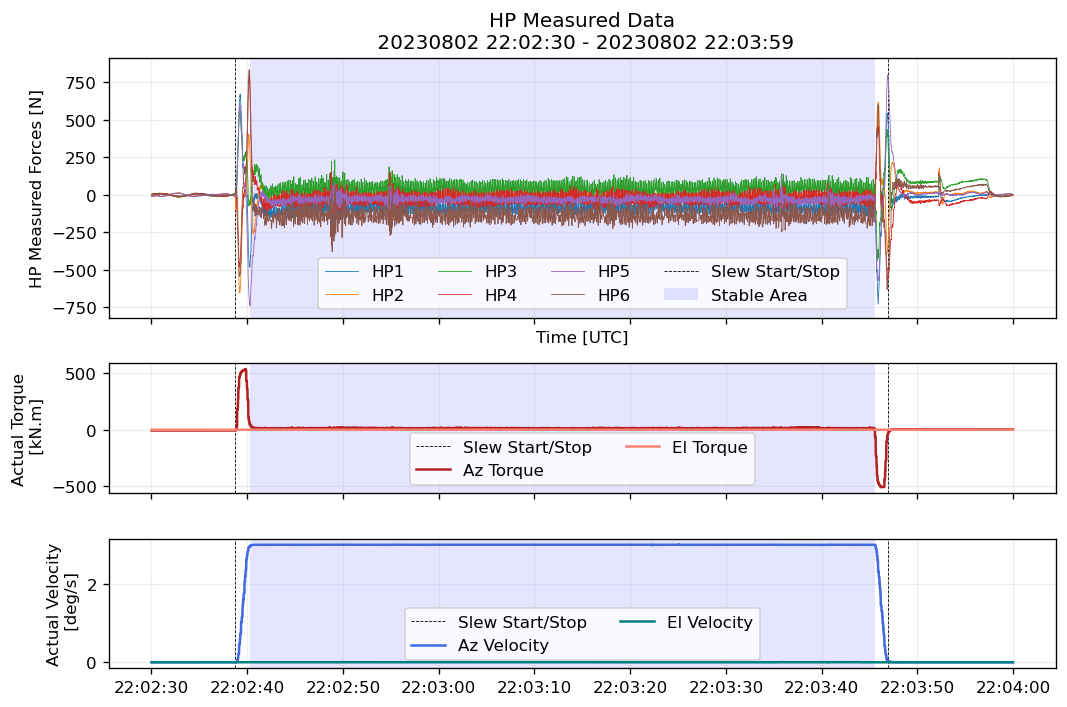

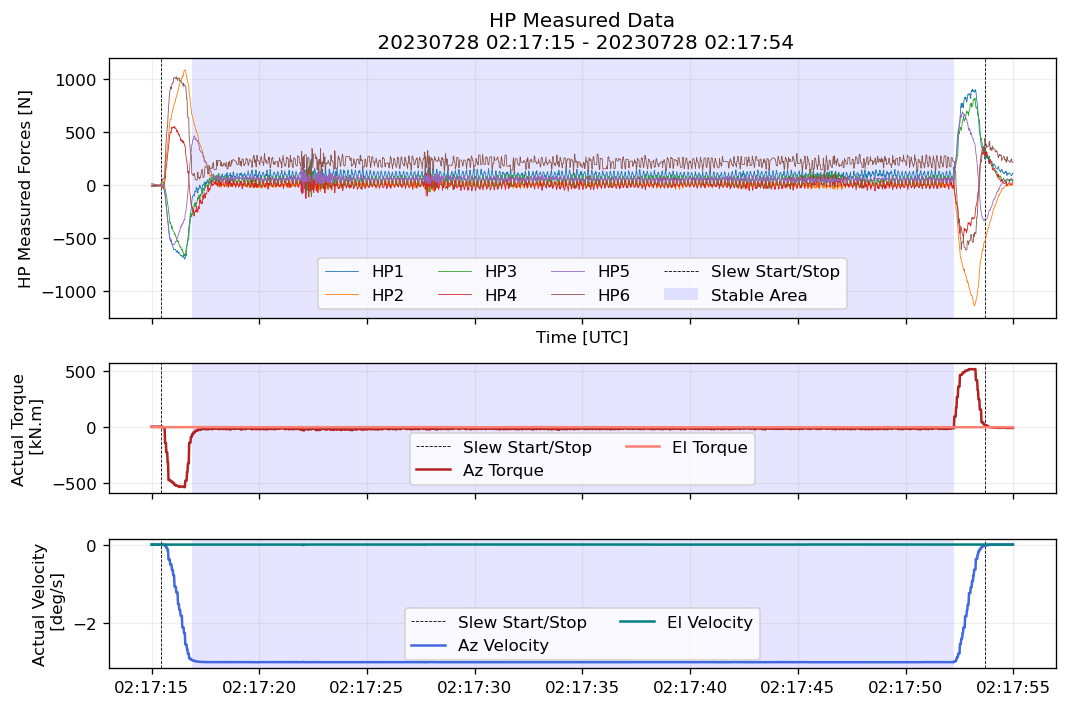

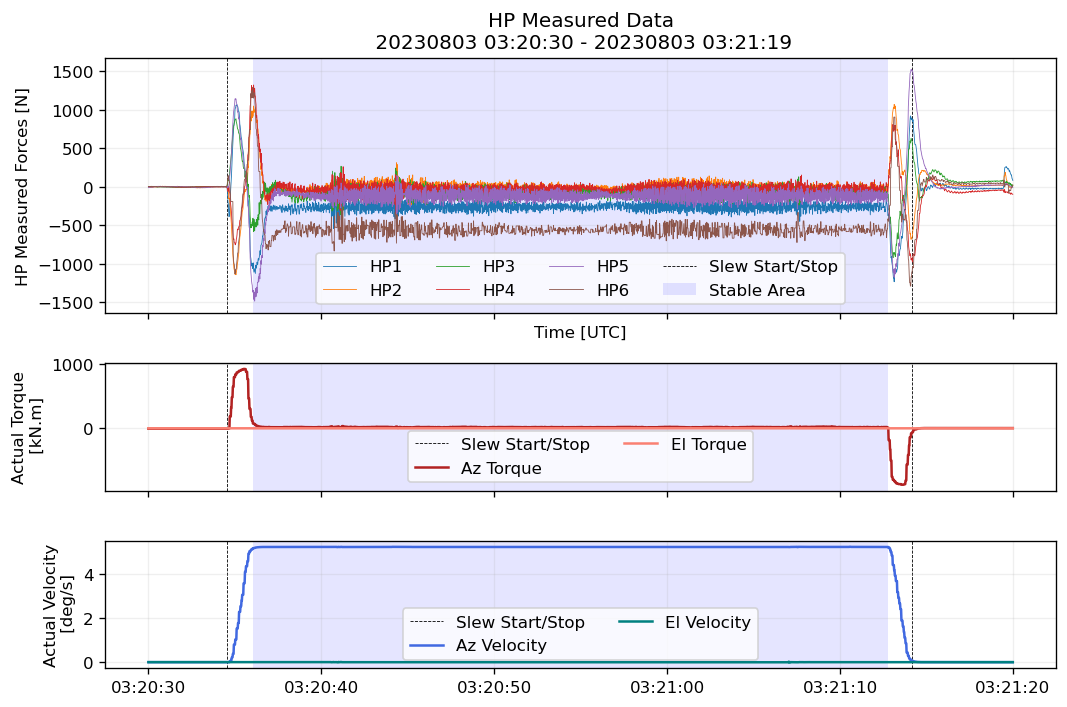

In [25]:
plot_hp_measured_data(dataset1)
plot_hp_measured_data(dataset2)
plot_hp_measured_data(dataset3)

In [26]:
print(dataset1.name)
dataset1.stats

Az Slew from -100 to 100 with 80 El, 30% motion settings and Inertia Compensation On


,min,max,ptp
measuredForce0,-727.673706,672.066711,1399.740417
measuredForce1,-652.610535,617.186279,1269.796814
measuredForce2,-435.129242,557.153381,992.282623
measuredForce3,-572.149597,781.137146,1353.286743
measuredForce4,-739.137207,799.200195,1538.337402
measuredForce5,-630.735229,834.526489,1465.261719
az_actual_torque,-508.782120,537.746971,1046.529091
az_actual_velocity,-0.000524,3.009254,3.009778
el_actual_torque,-1.434677,0.633590,2.068267
el_actual_velocity,-0.005064,0.004476,0.009540


In [ ]:
print(dataset2.name)
dataset2.stats

In [ ]:
print(dataset3.name)
dataset3.stats

In [ ]:
print(dataset1.name)
dataset1.integrals

In [ ]:
print(dataset2.name)
dataset2.integrals

In [ ]:
print(dataset3.name)
dataset3.integrals